In [1]:
import cv2
import matplotlib.pyplot as plt

In [2]:
Body_parts = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

Pose_pairs = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [3]:
in_width = 400
in_height = 400

In [4]:
net = cv2.dnn.readNetFromTensorflow('graph_opt.pb')

In [5]:
def pose_detection(frame):
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    
    net.setInput(cv2.dnn.blobFromImage(image=frame,scalefactor=1.0,size=(in_width,in_height),mean=(127.5, 127.5, 127.5),swapRB=True,crop=False))
#     net.setInput(cv2.dnn.blobFromImage(frame, 1.0, (in_width, in_height), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    points = []
    for i in range(len(Body_parts)):
        # Slice heatmap of corresponging body's part.
        heatmap = out[0, i, :, :]

        _, maxVal, _, maxLoc = cv2.minMaxLoc(heatmap)
        x = (frame_width * maxLoc[0]) / out.shape[3]
        y = (frame_height * maxLoc[1]) / out.shape[2]
        points.append((int(x), int(y)) if maxVal > 0.2 else None)

    for pair in Pose_pairs:
        part_from = pair[0]
        part_to = pair[1]

        id_from = Body_parts[part_from]
        id_to = Body_parts[part_to]

        if points[id_from] and points[id_to]:
            cv2.line(frame, points[id_from], points[id_to], (0, 255, 0), 3)
            cv2.ellipse(frame, points[id_from], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[id_to], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)

    t, _ = net.getPerfProfile()

    return frame

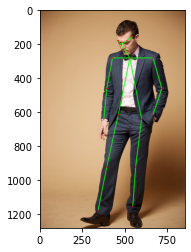

In [6]:
input = cv2.imread("image2.jpg")
output = pose_detection(input)
plt.imshow(cv2.cvtColor(output,cv2.COLOR_BGR2RGB))

In [11]:
cap = cv2.VideoCapture('video1.mp4')
cap.set(cv2.CAP_PROP_FPS,5)
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
result = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'MJPG'),10, size)
print('processing video')
while True:
    ret, frame = cap.read()
    if not ret:
        result.release()
        break
    output = pose_detection(frame)
#     cv2.imshow('output',output)
#     if cv2.waitKey(1) & 0xff == ord('q'):
#         break
    result.write(output)
cap.release()
cv2.destroyAllWindows()
print("Done processing video")

processing video
Done processing video
